# Self-Attention Generative Adversarial Network

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls

drive  sample_data


In [3]:
%cd ../content/drive/MyDrive/github/Pokemon-GAN/GAN-practice

/content/drive/MyDrive/github/Pokemon-GAN/GAN-practice


In [4]:
!nvidia-smi

Tue May  4 04:05:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image
import os

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [6]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


# Self Attention Layer

In [7]:
class Self_Attention(nn.Module):

    def __init__(self, in_dim):
        super(Self_Attention, self).__init__()
        # pointwise convolution
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        # Attention Map softmax
        self.softmax = nn.Softmax(dim=-2)

        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        X = x

        proj_query = self.query_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])
        proj_query = proj_query.permute(0, 2, 1)
        proj_key = self.key_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])

        S = torch.bmm(proj_query, proj_key)

        attention_map_T = self.softmax(S)
        attention_map = attention_map_T.permute(0, 2, 1)
        # Self-Attention
        proj_value = self.value_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])
        o = torch.bmm(proj_value, attention_map.permute(0,2,1))

        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x+self.gamma*o
        return out, attention_map

# Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim=20,image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size*8, kernel_size=4, stride=1)),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True))
        
        self.self_attention1 = Self_Attention(in_dim=image_size * 2)

        self.layer4 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*2, image_size*1, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.self_attention2 = Self_Attention(in_dim=image_size)

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh())

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2

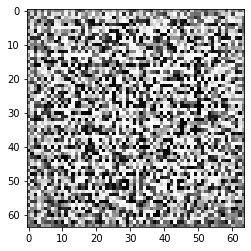

In [9]:
# Check
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

input_z = torch.randn(1, 20)

input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

fake_images, attention_map1, attention_map2 = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

# Disciminator

In [10]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer2 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.self_attention1 = Self_Attention(in_dim=image_size*4)

        self.layer4 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        self.self_attention2 = Self_Attention(in_dim=image_size*8)

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2

In [11]:
# Check
D = Discriminator(z_dim=20, image_size=64)

input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images, _, _ = G(input_z)

d_out, attention_map1, attention_map2 = D(fake_images)

print(nn.Sigmoid()(d_out))

tensor([[[[0.5001]]]], grad_fn=<SigmoidBackward>)


In [12]:
def make_datapath_list():

    train_img_list = list()

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list

class ImageTransform():

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

class GAN_Img_Dataset(data.Dataset):
    
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):

        img_path = self.file_list[index]
        img = Image.open(img_path)

        img_transformed = self.transform(img)

        return img_transformed

In [13]:
train_img_list=make_datapath_list()

mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

batch_size = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)
print(imges.size())

torch.Size([64, 1, 64, 64])


In [34]:
def train_model(G, D, dataloader, num_epochs, model_name=None):

    if model_name != None:
      if not os.path.isdir(f"./saved_model/{model_name}"):
        os.makedirs(f"./saved_model/{model_name}")
        os.makedirs(f"./saved_model/{model_name}/CPU/Generator")
        os.makedirs(f"./saved_model/{model_name}/CPU/Discriminator")
        os.makedirs(f"./saved_model/{model_name}/GPU/Generator")
        os.makedirs(f"./saved_model/{model_name}/GPU/Discriminator")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    z_dim = 20
    mini_batch_size = 64

    G.to(device)
    D.to(device)

    G.train()
    D.train()

    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    iteration = 1
    logs = []

    for epoch in range(num_epochs):

        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0

        print('-----------------')
        print(f"Epoch{epoch}/{num_epochs}")
        print('-----------------')
        print(' (train) ')

        for images in dataloader:
            # If batch size is 0, BatchNormLayer dont work 
            if images.size()[0] == 1:
                continue
            
            images = images.to(device)
            # make label
            mini_batch_size = images.size()[0]

            #######################
            # Discriminator train #
            #######################
            d_out_real, _, _ = D(images)
            # make fake images & predict
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)
            # calculate loss
            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
            d_loss = d_loss_real + d_loss_fake
            # back propagation
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            ###################
            # Generator train #
            ###################
            # make fake imagaes & predict
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)
            # calculate loss
            g_loss = - d_out_fake.mean()
            # back propagation
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            #############
            # Recording #
            #############
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        t_epoch_finish = time.time()
        print('-------------')
        print(f"epoch {epoch} || Epoch_D_Loss:{epoch_d_loss/batch_size:.4f} || Epoch_G_Loss:{epoch_g_loss/batch_size:.4f}")
        print(f"timer: {t_epoch_finish - t_epoch_start:.4f}")
        t_epoch_start = time.time()

        if model_name != None and epoch%10 == 0:
          model_path =  f"./saved_model/{model_name}"
          file_name = f"{epoch}.pth"
          torch.save(G.state_dict(), f"{model_path}/GPU/Generator/{file_name}")
          torch.save(D.state_dict(), f"{model_path}/GPU/Discriminator/{file_name}")
          torch.save(G.to('cpu').state_dict(), f"{model_path}/CPU/Generator/{file_name}")
          torch.save(D.to('cpu').state_dict(), f"{model_path}/CPU/Discriminator/{file_name}")
          G.to(device)
          D.to(device)

    if model_name != None:
          model_path =  f"./saved_model/{model_name}"
          file_name = f"{num_epochs}.pth"
          torch.save(G.state_dict(), f"{model_path}/GPU/Generator/{file_name}")
          torch.save(D.state_dict(), f"{model_path}/GPU/Discriminator/{file_name}")
          torch.save(G.to('cpu').state_dict(), f"{model_path}/CPU/Generator/{file_name}")
          torch.save(D.to('cpu').state_dict(), f"{model_path}/CPU/Discriminator/{file_name}")
          G.to(device)
          D.to(device)
    return G, D

In [35]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G.apply(weights_init)
D.apply(weights_init)

print("Network initialize completed")

Network initialize completed


In [36]:
num_epochs = 300
G_update, D_update = train_model(G, D, dataloader=train_dataloader, num_epochs=num_epochs)

Using device: cuda:0
-----------------
Epoch0/300
-----------------
 (train) 
-------------
epoch 0 || Epoch_D_Loss:0.0928 || Epoch_G_Loss:0.1065
timer: 1.6023
-----------------
Epoch1/300
-----------------
 (train) 
-------------
epoch 1 || Epoch_D_Loss:0.0050 || Epoch_G_Loss:0.1659
timer: 1.4981
-----------------
Epoch2/300
-----------------
 (train) 
-------------
epoch 2 || Epoch_D_Loss:0.0000 || Epoch_G_Loss:0.1830
timer: 1.4659
-----------------
Epoch3/300
-----------------
 (train) 
-------------
epoch 3 || Epoch_D_Loss:0.0001 || Epoch_G_Loss:0.1639
timer: 1.4755
-----------------
Epoch4/300
-----------------
 (train) 
-------------
epoch 4 || Epoch_D_Loss:0.0002 || Epoch_G_Loss:0.1610
timer: 1.4798
-----------------
Epoch5/300
-----------------
 (train) 
-------------
epoch 5 || Epoch_D_Loss:0.0037 || Epoch_G_Loss:0.1809
timer: 1.5157
-----------------
Epoch6/300
-----------------
 (train) 
-------------
epoch 6 || Epoch_D_Loss:0.0009 || Epoch_G_Loss:0.1956
timer: 1.4977
------

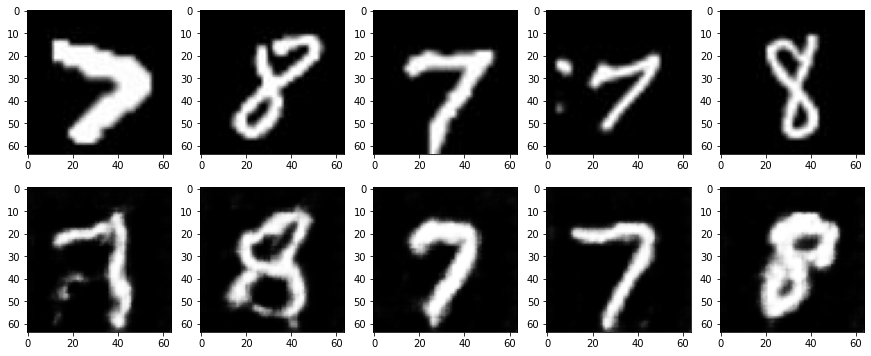

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

G_update.eval()
fake_images, am1, am2 = G_update(fixed_z.to(device))

batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

fig = plt.figure(figsize=(15,6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')